# Analyse descriptives - UT4M Cardio

**L'objectif de ce script est de proposer des visuels permettant de se familiariser avec des données UT4M sur le comportement cardiaques des utltra-trailers.**
**Nous présenterons également à la fin nos premières modélisation des données.**

In [1]:
using Pkg
Pkg.activate("./VisualisationToolKit")
Pkg.instantiate()

  Activating new project at `c:\Users\zergu\Documents\ut4m-cardio\Julia\Rendus\VisualisationToolKit`
  No Changes to `C:\Users\zergu\Documents\ut4m-cardio\Julia\Rendus\VisualisationToolKit\Project.toml`
  No Changes to `C:\Users\zergu\Documents\ut4m-cardio\Julia\Rendus\VisualisationToolKit\Manifest.toml`


In [2]:
using DataFrames, XLSX, StatsBase, DataFramesMeta, Plots, CSV, Statistics, StatsPlots, Interact, Blink, QuartoNotebookRunner, IJulia, DataStructures, 
GLM, StatsModels,HypothesisTests, CategoricalArrays, MultipleTesting

WebIO._IJuliaInit()

In [63]:
# Inclure le fichiers preprocessing.jl qui contient des fonctions permettant de nettoyer la base
include("../preprocessing.jl")
include("../plot.jl")

plot_combined_data

## Import et traitement des données

Voici un premier aperçu des données : 

In [4]:
gl = XLSX.readxlsx("../../Ressources/Données complètes UT4M final120419 avec Data cardio.xlsx")["Tableau_gl"]
gl = gl["A1:SD80"]

# Passage de matrice à DataFrame
df = DataFrame(gl[2:end, 2:end], Symbol.(gl[1, 2:end]), makeunique=true)
CODE_SUJET = DataFrame([:"CODE_SUJET" => gl[2:end,1]])
df = hcat(CODE_SUJET, df)
first(df, 5)

5×498 DataFrame
 Row │ CODE_SUJET  COURSE  AGE  POIDS_INC  TAILLE  EXP_TRAIL  TRAINING  CL_SCR ⋯
     │ Any         Any     Any  Any        Any     Any        Any       Any    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ AMJE41      100     26   72         176     4          3.5       461    ⋯
   2 │ BELA77      100     51   64         178     4          3.5       248
   3 │ BLLI42      100     43   65         175     4          2.5       261
   4 │ BOAN44      100     26   51         165     4          3         410
   5 │ CAJE22      100     36   78         172     4          4         112    ⋯
                                                             491 columns omitted

### Le nombre d'individus par course

In [28]:
grouped = groupby(df, :COURSE)
nparcourse = DataFrames.combine(grouped,nrow)

4×2 DataFrame
 Row │ COURSE  nrow  
     │ Any     Int64 
─────┼───────────────
   1 │ 100        12
   2 │ 4_40       20
   3 │ 40         18
   4 │ 160        29

### Le taux de DNF et DNA 

In [22]:
# Comptage des abandons
grouped = groupby(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])], :COURSE)
cols = names(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])]) .!= "COURSE"
nmissing_per_group = DataFrames.combine(grouped, 
    [col => (x -> sum(y -> y == 999, x)) => Symbol(string(col)) for col in names(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])]) if col != "COURSE"]...)

4×492 DataFrame
 Row │ COURSE  CL_SCRA  TOT_SCRA  CL_SEH  TOT_SEH  CL_SEF  TOT_SEF  CL_V1H  TO ⋯
     │ Any     Int64    Int64     Int64   Int64    Int64   Int64    Int64   In ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 100           1         1       1        1       1        1       1     ⋯
   2 │ 4_40          4         4       4        4       4        4       4
   3 │ 40            0         0       0        0       0        0       0
   4 │ 160          11        11      11       11      11       11      11
                                                             484 columns omitted

In [23]:
# Comptage des non parpicipants
grouped = groupby(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])], :COURSE)
cols = names(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])]) .!= "COURSE"
nmissing_per_group = DataFrames.combine(grouped, 
    [col => (x -> sum(y -> y == 998, x)) => Symbol(string(col)) for col in names(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])]) if col != "COURSE"]...)

4×492 DataFrame
 Row │ COURSE  CL_SCRA  TOT_SCRA  CL_SEH  TOT_SEH  CL_SEF  TOT_SEF  CL_V1H  TO ⋯
     │ Any     Int64    Int64     Int64   Int64    Int64   Int64    Int64   In ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 100           0         0       4        4      10       10       9     ⋯
   2 │ 4_40          0         0       9        9      14       14      11
   3 │ 40            0         0      10       10      16       16      13
   4 │ 160           0         0      13       13      18       18      10
                                                             484 columns omitted

In [35]:
grouped = groupby(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])], :COURSE)
cols = names(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])]) .!= "COURSE"

nmissing_per_group = DataFrames.combine(grouped, 
    [col => (x -> sum(y -> !ismissing(y) && (y == 998 || y == 999), x)) => Symbol(string(col)) for col in names(df[:, Not([:POIDS_INC, :TAILLE, :EXP_TRAIL, :TRAINING, :AGE, :CODE_SUJET])]) if col != "COURSE"]...)


4×492 DataFrame
 Row │ COURSE  CL_SCRA  TOT_SCRA  CL_SEH  TOT_SEH  CL_SEF  TOT_SEF  CL_V1H  TO ⋯
     │ Any     Int64    Int64     Int64   Int64    Int64   Int64    Int64   In ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 100           1         1       5        5      11       11      10     ⋯
   2 │ 4_40          4         4      13       13      18       18      15
   3 │ 40            0         0      10       10      16       16      13
   4 │ 160          11        11      24       24      29       29      21
                                                             484 columns omitted

> **Remarques** : Pour la course 160 km, il y a que des abandons ou non-participation

### Remplacement des -1 par des NA et supprimer les non-participations

Dans un premier temps, notre travail de pré-traitement des données commence par le remplacement des -1 par des NA (missing en Julia). Ainsi qu'une suppression des non-participations (et des abandons ?). Voici un aperçu de la modification : 

In [ ]:
#| echo: false
#| message: false
df = replaceDF(df, -1, missing)
first(df[:, 260:265],3)

In [39]:
# Pour supprimer les non-participations à la course, on se base sur la colonne qui donne le temps à l'arrivée -
deleteDNA(df)

63×498 DataFrame
 Row │ CODE_SUJET  COURSE  AGE  POIDS_INC  TAILLE  EXP_TRAIL  TRAINING  CL_SCR ⋯
     │ Any         Any     Any  Any        Any     Any        Any       Any    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ AMJE41      100     26   72         176     4          3.5       461    ⋯
   2 │ BELA77      100     51   64         178     4          3.5       248
   3 │ BLLI42      100     43   65         175     4          2.5       261
   4 │ BOAN44      100     26   51         165     4          3         410
   5 │ CAJE22      100     36   78         172     4          4         112    ⋯
   6 │ GODA23      100     30   75         181     4          3         154
   7 │ MEJE46      100     35   59         165     2          2         224
   8 │ MOMI6       100     35   77         179     4          4         183
   9 │ MOQU74      100     30   78         180     4          5         329    ⋯
  10 │ POFR81      100     42   70         179     4          6         131
  11 │ SEFL43      100     26   71         179     4          3         213
  ⋮  │     ⋮         ⋮      ⋮       ⋮        ⋮         ⋮         ⋮         ⋮   ⋱
  54 │ GUDA24      160     43   67         178     4          4         127
  55 │ LELA15      160     40   71         175     4          3         131    ⋯
  56 │ MAST16      160     46   68         169     4          5.5       103
  57 │ PIMA13      160     32   76         174     4          5         197
  58 │ POST14      160     48   67         180     4          2         85
  59 │ POPI57      160     26   61         172     2          4         199    ⋯
  60 │ POMA80      160     50   76         180     4          4         162
  61 │ POBE49      160     53   56         166     4          4.5       239
  62 │ RIJE65      160     54   72         168     4          4.5       91
  63 │ SESE27      160     38   52         167     4          3         50     ⋯
                                                 491 columns and 42 rows omitted

> On passe alors de 79 à 63 individus

### Passer de données en colonnes à données en lignes

Dans un second temps, nous passons les données de colonnes vers des données lignes pour avoir une colonne TIME qui représente les différentes visites (PRE, POST, D2, D5 et D10).

Voici comment sont représenté les données colonnes : 

In [41]:
mesures = df[:,24:213]
mesures_cardiaques = df[:,267:end]
first(mesures_cardiaques, 3)

3×232 DataFrame
 Row │ PAS_PRE  PAD_PRE  PAM_PRE  SC    FC_PRE  S_PRE  DTDVG_PRE  DTDVGI_PRE   ⋯
     │ Any      Any      Any      Any   Any     Any    Any        Any          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 132      80       97.3333  1.87  58      10     48         25.6684      ⋯
   2 │ 117      68       84.3333  1.79  60      10     45         25.1397
   3 │ 126      74       91.3333  1.8   55      10     47         26.1111
                                                             224 columns omitted

Voici le passage en données lignes (création d'une variable TIME et réduction du nombre de colonnes) : 

In [54]:
res = colToRow(mesures_cardiaques)
first(res, 5)

5×51 DataFrame
 Row │ TIME   STDi     DTDVGI   At   TDM  PP   VOL_OGI  ITVPUL   Et   E/A_1    ⋯
     │ Int64  Any      Any      Any  Any  Any  Any      Any      Any  Missing  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    -2  12.3529  25.6684  28   203  9    27.2727  missing  66   missing  ⋯
   2 │    -2  11.5642  25.1397  25   255  10   24.581   missing  52   missing 
   3 │    -2  12       26.1111  26   215  10   33.3333  missing  53   missing 
   4 │    -2  11.5686  28.7582  17   201  9    28.1046  missing  48   missing 
   5 │    -2  13.6316  30.5263  26   185  12   54.2105  missing  50   missing  ⋯
                                                              41 columns omitted

Le nombre de colonnes est alors passé de 232 à 53.

Ensuite, on anonymise les individus : 

In [55]:
#| results: hide
res = addCOURSE_SUJET(df, res)

315×53 DataFrame
 Row │ CODE_SUJET  COURSE  TIME   STDi     DTDVGI   At       TDM      PP       ⋯
     │ Int64       Any     Int64  Any      Any      Any      Any      Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │          1  100        -2  12.3529  25.6684  28       203      9        ⋯
   2 │          2  100        -2  11.5642  25.1397  25       255      10
   3 │          3  100        -2  12       26.1111  26       215      10
   4 │          4  100        -2  11.5686  28.7582  17       201      9
   5 │          5  100        -2  13.6316  30.5263  26       185      12       ⋯
   6 │          6  100        -2  12.1026  29.2308  20       327      10
   7 │          7  100        -2  12.1341  34.7561  31       206      9
   8 │          8  100        -2  9.53846  25.641   24       224      9
   9 │          9  100        -2  12.4873  25.3807  missing  278      10       ⋯
  10 │         10  100        -2  12.7273  27.2727  19       235      9
  11 │         11  100        -2  16.2766  29.2553  22       196      9
  ⋮  │     ⋮         ⋮       ⋮       ⋮        ⋮        ⋮        ⋮        ⋮     ⋱
 306 │         54  160        11  12.4044  26.2295  30       151      10
 307 │         55  160        11  11.027   30.2703  25       224      9        ⋯
 308 │         56  160        11  12.4719  27.5281  23       187      10
 309 │         57  160        11  13.9474  27.8947  35       149      9
 310 │         58  160        11  12.4865  27.027   22       218      9
 311 │         59  160        11  15.3488  27.3256  32       197      10       ⋯
 312 │         60  160        11  missing  missing  missing  missing  missing 
 313 │         61  160        11  10.9317  29.1925  21       213      8
 314 │         62  160        11  15.4696  25.9669  28       209      10
 315 │         63  160        11  11.871   32.9032  17       178      9        ⋯
                                                 45 columns and 294 rows omitted

## Analyse des données

**Dans un premier temps nos analyses des données reposent sur 8 variables d'intérêts :**

- VOL_OGI (Volume de l'oreillette gauche indexé)
- VOL_ODI (Volume de l'oreillette droite indexé)
- VTDVGI 
- VTSVGI 
- FE2D
- FRVD
- STDi 
- STSi
- E/A
- E/Ea

In [58]:
#| results: hide
VI = ["CODE_SUJET", "COURSE", "TIME", "VOL_OGI", "VOL_ODI", "VTDVGI", "VTSVGI", "FE2D", "FRVD", "STDi", "STSi", "E/A", "E/Ea"]
res = res[:,VI]

315×13 DataFrame
 Row │ CODE_SUJET  COURSE  TIME   VOL_OGI  VOL_ODI  VTDVGI   VTSVGI   FE2D     ⋯
     │ Int64       Any     Int64  Any      Any      Any      Any      Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │          1  100        -2  27.2727  24.5989  72.1925  31.5508  58       ⋯
   2 │          2  100        -2  24.581   32.9609  61.4525  22.905   63
   3 │          3  100        -2  33.3333  23.3333  50.5556  24.4444  52
   4 │          4  100        -2  28.1046  20.915   52.9412  24.8366  53
   5 │          5  100        -2  54.2105  39.4737  64.7368  30.5263  53       ⋯
   6 │          6  100        -2  36.9231  39.4872  68.7179  31.2821  54
   7 │          7  100        -2  50       36.5854  74.3902  32.3171  57
   8 │          8  100        -2  32.3077  23.0769  69.7436  31.2821  55
   9 │          9  100        -2  41.1168  40.1015  59.8985  29.4416  50       ⋯
  10 │         10  100        -2  38.5027  48.1283  58.2888  23.5294  60
  11 │         11  100        -2  35.1064  27.1277  71.2766  34.0426  52
  ⋮  │     ⋮         ⋮       ⋮       ⋮        ⋮        ⋮        ⋮        ⋮     ⋱
 306 │         54  160        11  30.6011  27.8689  58.4699  25.1366  57
 307 │         55  160        11  50.2703  39.4595  72.4324  36.2162  50       ⋯
 308 │         56  160        11  33.1461  32.0225  65.1685  29.7753  55
 309 │         57  160        11  43.1579  33.1579  67.8947  34.7368  58
 310 │         58  160        11  45.9459  31.8919  57.8378  29.1892  54
 311 │         59  160        11  34.3023  30.2326  65.6977  27.907   54       ⋯
 312 │         60  160        11  missing  missing  missing  missing  missing 
 313 │         61  160        11  43.4783  32.9193  52.795   23.6025  59
 314 │         62  160        11  48.6188  50.2762  66.8508  26.5193  59
 315 │         63  160        11  39.3548  32.2581  56.129   20       65       ⋯
                                                  5 columns and 294 rows omitted

### Résumés statistiques


Réalisons maintenant les résumés statistiques sur nos 8 variables d'intérêt.

In [61]:
describe(res[:,4:11])[:,1:6]
pourcent = convert.(Int64, round.(((describe(res[:,4:end])[:,6]/395)*100),digits=0))
pourcent = string.(pourcent)
pourcent = pourcent.*"%"
statistiques = hcat(describe(res[:,4:end])[:,1:6], pourcent)
rename!(statistiques, :x1 => "%missing")

10×7 DataFrame
 Row │ variable  mean       min        median     max        nmissing  %missin ⋯
     │ Symbol    Float64    Real       Float64    Real       Int64     String  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ VOL_OGI   41.2966    24.581     40.1731    73.3696          25  6%      ⋯
   2 │ VOL_ODI   34.7268    15.1351    33.7794    60.3261          25  6%
   3 │ VTDVGI    62.8662     1.0       62.4861    91.4894          25  6%
   4 │ VTSVGI    28.1349     1.0       27.6836    45.2128          26  7%
   5 │ FE2D      55.7789    40         55.0       71               30  8%      ⋯
   6 │ FRVD       0.448615   0.26699    0.451054   0.639731        25  6%
   7 │ STDi      12.6503     7.51351   12.6741    17.6882          25  6%
   8 │ STSi       6.9799     3.45946    6.934     10.7895          25  6%
   9 │ E/A        1.65878    0.591549   1.65       3.76923         26  7%      ⋯
  10 │ E/Ea       4.74402    2.72222    4.42105   10.1             30  8%
                                                                1 column omitted

#### Compter les valeurs manquantes

Dans cette section, nous allons compter les valeurs manquantes en prenant en compte les courses, les vistes et les individus.

In [88]:
#| results: hide
describe(res[:,Not([:CODE_SUJET, :COURSE, :TIME])], :nmissing)

8×2 DataFrame
 Row │ variable  nmissing 
     │ Symbol    Int64    
─────┼────────────────────
   1 │ VOL_OGI        318
   2 │ VOL_ODI        318
   3 │ VTDVGI          85
   4 │ VTSVGI          86
   5 │ FE2D            97
   6 │ FRVD            89
   7 │ STDi            89
   8 │ STSi            89

Le nombre de données manquantes par visite et par mesure cardiaque : 

In [89]:
# Le nombre de données manquantes par visite et par mesure cardiaque
grouped = groupby(res[:,Not([:CODE_SUJET, :COURSE])], :TIME)
cols = names(res[:,Not([:CODE_SUJET, :COURSE])]) .!= "TIME"
nmissing_per_group = combine(grouped, 
    [col => (x -> sum(ismissing, x)) => Symbol(string(col)) for col in names(res[:,Not([:CODE_SUJET, :COURSE])]) if col != "TIME"]...)

5×9 DataFrame
 Row │ TIME   VOL_OGI  VOL_ODI  VTDVGI  VTSVGI  FE2D   FRVD   STDi   STSi  
     │ Int64  Int64    Int64    Int64   Int64   Int64  Int64  Int64  Int64 
─────┼─────────────────────────────────────────────────────────────────────
   1 │    -2        2        2       5       5      5      2      2      2
   2 │     1       79       79      22      23     24     21     21     21
   3 │     3       79       79      22      22     22     22     22     22
   4 │     6       79       79      12      12     22     20     20     20
   5 │    11       79       79      24      24     24     24     24     24

**Remarques : pour le volume de l'oreillette gauche et droite, nous avons des données seulement à J-2. Dans la suite, nous n'étudirons que les 6 autres mesures cardiaques.**

Le nombre de données manquantes par sujet et par mesure cardiaque : 

In [ ]:
#| results: hide
liste_VI = ["VTDVGI","VTSVGI","FE2D","FRVD","STDi","STSi", "E/A", "E/Ea"]

In [90]:
#| results: hide
VI = [:CODE_SUJET, :COURSE, :TIME, :VTDVGI, :VTSVGI, :FE2D, :FRVD, :STDi, :STSi]
res = res[:,VI]

395×9 DataFrame
 Row │ CODE_SUJET  COURSE  TIME   VTDVGI   VTSVGI   FE2D     FRVD      STDi    ⋯
     │ Int64       Any     Int64  Any      Any      Any      Any       Any     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │          1  100        -2  72.1925  31.5508  58       0.467532  12.3529 ⋯
   2 │          2  100        -2  61.4525  22.905   63       0.536232  11.5642
   3 │          3  100        -2  50.5556  24.4444  52       0.560185  12
   4 │          4  100        -2  52.9412  24.8366  53       0.514124  11.5686
   5 │          5  100        -2  64.7368  30.5263  53       0.498069  13.6316 ⋯
   6 │          6  100        -2  68.7179  31.2821  54       0.368644  12.1026
   7 │          7  100        -2  70.2439  33.6585  52       0.378571  13.6585
   8 │          8  100        -2  74.3902  32.3171  57       0.472362  12.1341
   9 │          9  100        -2  69.7436  31.2821  55       0.376344  9.53846 ⋯
  10 │         10  100        -2  59.8985  29.4416  50       0.479675  12.4873
  11 │         11  100        -2  58.2888  23.5294  60       0.508403  12.7273
  ⋮  │     ⋮         ⋮       ⋮       ⋮        ⋮        ⋮        ⋮         ⋮    ⋱
 386 │         70  160        11  missing  missing  missing  missing   missing
 387 │         71  160        11  67.8947  34.7368  58       0.49434   13.9474 ⋯
 388 │         72  160        11  57.8378  29.1892  54       0.445887  12.4865
 389 │         73  160        11  65.6977  27.907   54       0.462121  15.3488
 390 │         74  160        11  missing  missing  missing  missing   missing
 391 │         75  160        11  52.795   23.6025  59       0.482955  10.9317 ⋯
 392 │         76  160        11  66.8508  26.5193  59       0.432143  15.4696
 393 │         77  160        11  56.129   20       65       0.413043  11.871
 394 │         78  160        11  missing  missing  missing  missing   missing
 395 │         79  160        11  missing  missing  missing  missing   missing ⋯
                                                   1 column and 374 rows omitted

In [91]:
# Le nombre de données manquantes par sujet et par mesure cardiaque
grouped = groupby(res[:,Not([:COURSE, :TIME])], :CODE_SUJET)
cols = names(res[:,Not([:COURSE, :TIME])]) .!= "CODE_SUJET"
nmissing_per_group = combine(grouped, 
    [col => (x -> sum(ismissing, x)) => Symbol(string(col)) for col in names(res[:,Not([:COURSE, :TIME])]) if col != "CODE_SUJET"]...)

79×7 DataFrame
 Row │ CODE_SUJET  VTDVGI  VTSVGI  FE2D   FRVD   STDi   STSi  
     │ Int64       Int64   Int64   Int64  Int64  Int64  Int64 
─────┼────────────────────────────────────────────────────────
   1 │          1       0       0      1      0      0      0
   2 │          2       2       3      3      2      2      2
   3 │          3       0       0      1      0      0      0
   4 │          4       0       0      0      0      0      0
   5 │          5       0       0      0      0      0      0
   6 │          6       0       0      0      0      0      0
   7 │          7       4       4      4      4      4      4
   8 │          8       0       0      0      0      0      0
   9 │          9       0       0      0      0      0      0
  10 │         10       0       0      0      0      0      0
  11 │         11       0       0      0      0      0      0
  ⋮  │     ⋮         ⋮       ⋮       ⋮      ⋮      ⋮      ⋮
  70 │         70       3       3      4      4      4      4
  71 │         71       0       0      0      0      0      0
  72 │         72       0       0      0      0      0      0
  73 │         73       0       0      0      0      0      0
  74 │         74       1       1      1      1      1      1
  75 │         75       0       0      0      0      0      0
  76 │         76       0       0      0      0      0      0
  77 │         77       0       0      0      0      0      0
  78 │         78       4       4      4      4      4      4
  79 │         79       4       4      4      4      4      4
                                               58 rows omitted

**Remarque : Il y a quelques sujets, notamment le 7,27 et le 30 qui ont très peu de données, ces individus n'ont fait qu'une visite !**

Ici, nous affichons le nombre de données manquantes par sujet et par visite : 

In [16]:
# Grouper par CODE_SUJET et TIME, le nombre de missing
grouped = groupby(res, [:CODE_SUJET, :TIME])
function countmissing(res)
    cols = names(res)
    cols = filter(c -> c != :CODE_SUJET && c != :TIME, cols)
    totalmissing = 0
    for col in cols
        totalmissing += sum(ismissing, res[!, col])
    end
    return totalmissing
end
nmissing = combine(grouped, countmissing)
nmissing = unstack(nmissing, :CODE_SUJET, :TIME, :x1)

79×6 DataFrame
 Row │ CODE_SUJET  -2      1       3       6       11     
     │ Int64       Int64?  Int64?  Int64?  Int64?  Int64? 
─────┼────────────────────────────────────────────────────
   1 │          1       0       2       2       3       2
   2 │          2       0       4       8       8       2
   3 │          3       0       3       2       2       2
   4 │          4       0       2       2       2       2
   5 │          5       0       2       2       2       2
   6 │          6       0       2       2       2       2
   7 │          7       0       8       8       8       8
   8 │          8       0       2       2       2       2
   9 │          9       0       2       2       2       2
  10 │         10       0       2       2       2       2
  11 │         11       0       2       2       2       2
  ⋮  │     ⋮         ⋮       ⋮       ⋮       ⋮       ⋮
  70 │         70       0       8       8       6       8
  71 │         71       0       2       2       2       2
  72 │         72       0       2       2       2       2
  73 │         73       0       2       2       2       2
  74 │         74       0       2       2       2       8
  75 │         75       0       2       2       2       2
  76 │         76       0       2       2       2       2
  77 │         77       0       2       2       2       2
  78 │         78       0       8       8       8       8
  79 │         79       0       8       8       8       8
                                           58 rows omitted

####  Représentations visuelles des variables d'intérêts

Voici les spaghettis plot pour toutes les variables d'intérêt pour la course 100km :  

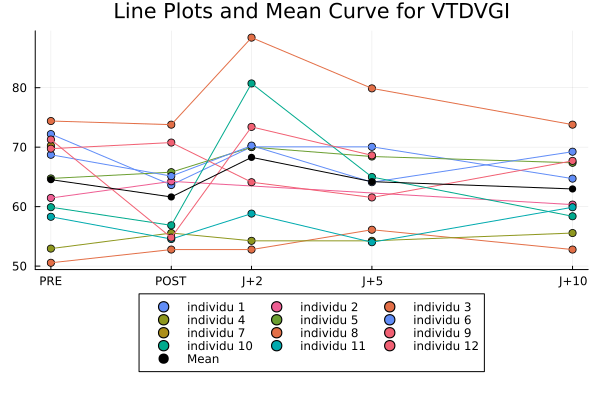

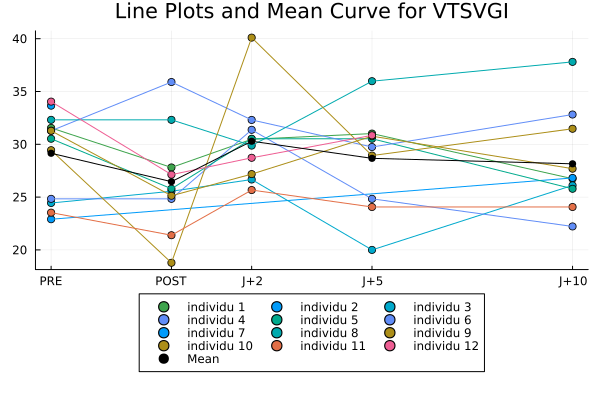

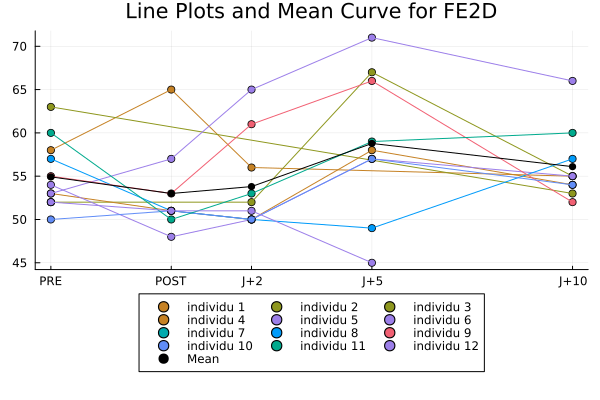

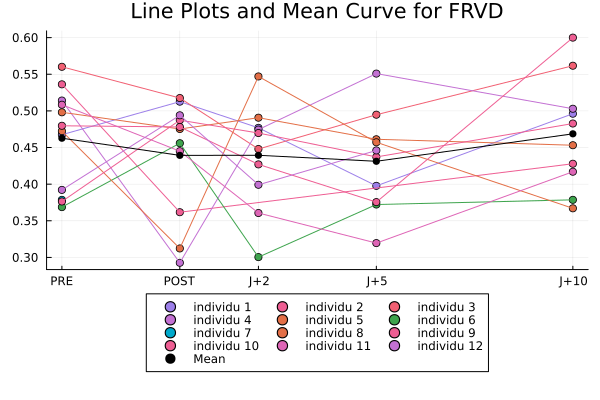

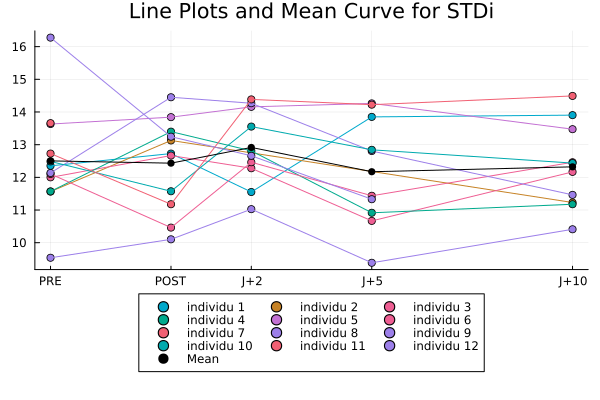

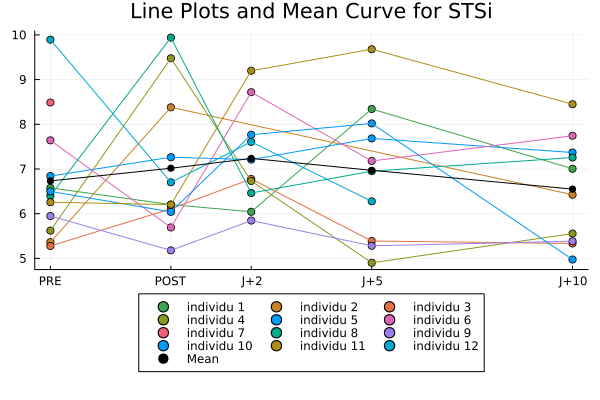

In [171]:
grouped_res = groupby(res, :COURSE)
course_100 = grouped_res[1]
groupe_ind_100 = groupby(course_100,:CODE_SUJET)
res_100 = filter(row -> row.COURSE == 100, res)
grouped_time_100 = groupby(res_100,:TIME)

for vi in liste_VI
    display(plot_combined_data(groupe_ind_100, grouped_time_100, vi))
end

####  Variabilité intra-individuelle et inter-individuelle

In [100]:
#| results: hide

# Passage des colonnes Any en float64
for col in names(res[:, 4:end])
    res[!, col] = [ismissing(x) ? missing : Float64(x) for x in res[!, col]]
end

Moyenne et ecart-type par individu (intra-individuel)

Dans cette partie, nous donnons la moyenne et l'écart-type par individu sous forme de tableau, puis nous l'illustrons avec des représentations graphiques. 

In [195]:
#|results: hide
function mean_std(x)
    non_missing_values = skipmissing(x)
    non_missing_values = collect(non_missing_values)
    
    if isempty(non_missing_values)
        return (NaN, NaN)
    else
        mean_val = round(mean(non_missing_values), digits=1)
        std_val = round(std(non_missing_values), digits=1)
        return (mean_val, std_val)
    end
end
grouped = groupby(res[:, 1:end], [:CODE_SUJET, :COURSE])
result = combine(grouped, names(res, Not([:CODE_SUJET, :COURSE, :TIME])) .=> mean_std)

79×8 DataFrame
 Row │ CODE_SUJET  COURSE  VTDVGI_mean_std  VTSVGI_mean_std  FE2D_mean_std  FR ⋯
     │ Int64       Any     Tuple…           Tuple…           Tuple…         Tu ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │          1  100     (68.1, 3.7)      (29.5, 2.1)      (58.5, 4.5)    (0 ⋯
   2 │          2  100     (62.0, 2.0)      (24.9, 2.8)      (58.0, 7.1)    (0
   3 │          3  100     (53.0, 2.0)      (24.6, 2.7)      (56.5, 7.1)    (0
   4 │          4  100     (54.5, 1.1)      (25.6, 3.4)      (53.2, 3.1)    (0
   5 │          5  100     (67.3, 2.1)      (28.6, 2.6)      (62.4, 7.3)    (0 ⋯
   6 │          6  100     (67.5, 2.7)      (32.4, 2.3)      (52.8, 3.7)    (0
   7 │          7  100     (70.2, NaN)      (33.7, NaN)      (52.0, NaN)    (0
   8 │          8  100     (78.0, 6.3)      (33.7, 3.2)      (52.8, 3.9)    (0
   9 │          9  100     (66.8, 3.9)      (28.4, 2.6)      (57.4, 5.9)    (0 ⋯
  10 │         10  100     (64.2, 9.7)      (29.7, 7.6)      (52.4, 3.0)    (0
  11 │         11  100     (57.1, 2.7)      (23.7, 1.5)      (56.4, 4.6)    (0
  ⋮  │     ⋮         ⋮            ⋮                ⋮               ⋮           ⋱
  70 │         70  160     (36.3, 52.2)     (15.1, 22.2)     (58.0, NaN)    (0
  71 │         71  160     (68.1, 3.3)      (34.3, 3.7)      (54.4, 4.3)    (0 ⋯
  72 │         72  160     (60.2, 4.7)      (29.4, 1.5)      (57.6, 5.4)    (0
  73 │         73  160     (71.3, 3.3)      (29.1, 1.2)      (56.4, 3.6)    (0
  74 │         74  160     (68.6, 2.2)      (29.6, 0.8)      (56.8, 4.1)    (0
  75 │         75  160     (56.0, 2.2)      (25.7, 1.8)      (54.0, 3.9)    (0 ⋯
  76 │         76  160     (68.3, 6.8)      (29.4, 4.6)      (56.6, 2.9)    (0
  77 │         77  160     (57.0, 3.0)      (24.8, 4.2)      (58.2, 4.2)    (0
  78 │         78  160     (86.8, NaN)      (48.4, NaN)      (44.0, NaN)    (0
  79 │         79  160     (73.6, NaN)      (33.0, NaN)      (55.0, NaN)    (0 ⋯
                                                   3 columns and 58 rows omitted

Voici quelques exemples de représentations graphiques de la varaibilité intra-individuelle pour une course donnée (100 km) : 

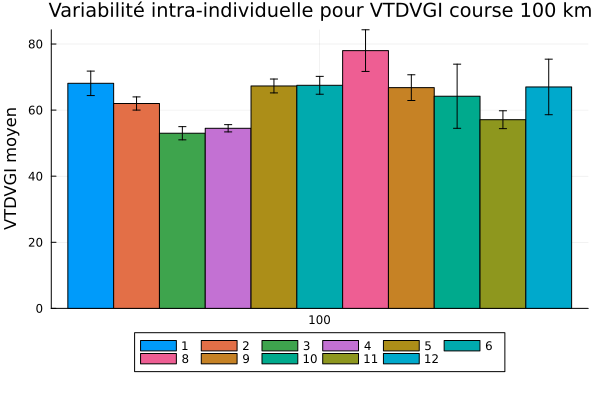

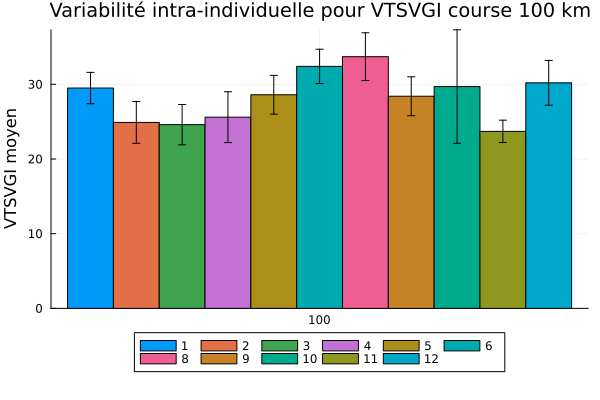

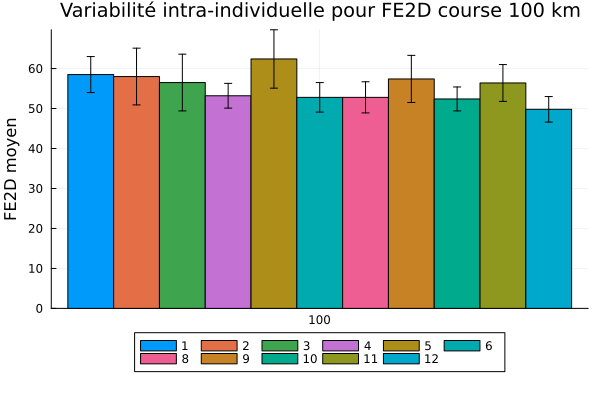

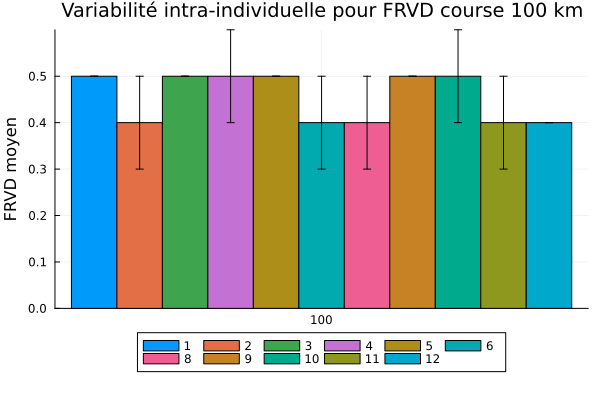

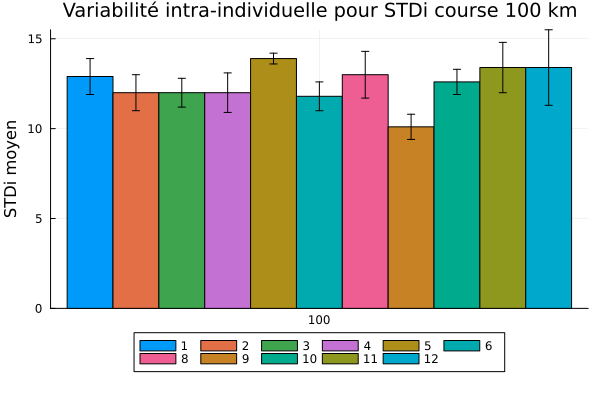

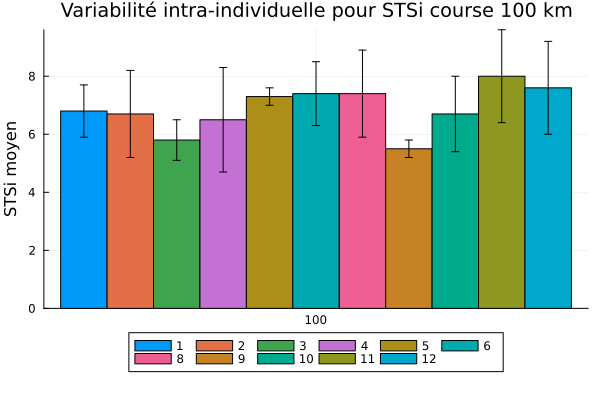

In [135]:
# Création d'une fonction pour afficher la variabilité intra-individuelle par course
function plotvariabilityintra(df, col, course)
    col2 = col*"_mean_std"
    df = filter(row -> row.COURSE == course, df)
    df = hcat(df[:, 1:2], getindex.(df[:,Symbol(col2)], 1), getindex.(df[:,Symbol(col2)], 2), makeunique=true)
    df = filter(row -> !ismissing(row[:x1]) && !isnan(row[:x1]), df)
    df = filter(row -> !ismissing(row[:x1_1]) && !isnan(row[:x1_1]), df)

    return groupedbar(df[:,2], df[:,3], yerr = df[:,4], group = df[:,1], ylabel = col*" moyen", # , xticks=([-2, 1, 3, 6, 11],xlab)
        title = "Variabilité intra-individuelle pour "*col*" course "*string(course)*" km", legend = :outerbottom, legendcolumns = 6,titlefontsize = 13)
end
for vi in ["VTDVGI","VTSVGI","FE2D","FRVD","STDi","STSi"]
    display(plotvariabilityintra(result, vi, 100))
end

In [130]:
#| results: hide

# Création d'une fonction pour afficher la variabilité intra-individuelle par course et par visite
function plotvariabilityintra(df, col)
    col2 = col*"_mean_std"
    df = hcat(df[:, 2:3], getindex.(df[:,Symbol(col2)], 1))
    df = filter(row -> !ismissing(row[:x1]) && !isnan(row[:x1]), df)
    # Replacement des valeurs de time 
    replacements = Dict(-2 => "J-2", 1 => "J+1", 3 => "J+3", 6 => "J+6", 11 => "J+11")
    df.TIME = map(x -> get(replacements, x, x), df.TIME)

    # Remplacement des valeurs de courses
    df.COURSE = string.(df.COURSE)
    replacements = Dict("100" => "100km (n="*string(counter(df.COURSE)["100"])*")",
         "4_40" => "4x40km (n="*string(counter(df.COURSE)["4_40"])*")",
          "160" => "160km (n="*string(counter(df.COURSE)["160"])*")",
           "40" => "40km (n="*string(counter(df.COURSE)["40"])*")")
    df.COURSE = map(x -> get(replacements, x, x), df.COURSE)
    # grouped = groupby(res[:, 1:end], [:CODE_SUJET, :COURSE, :TIME])
    return groupedboxplot(df[:,2], df[:,3], group=df[:,1],bar_width = 0.8, title="Variabilité intra-individuelle pour "*col)
end
plotvariabilityintra(result, "VTDVGI")

LoadError: ArgumentError: column name :TIME not found in the data frame

Moyenne et ecart-type par course et par temps (inter-individuel)

Voici le résultat de la variabilité inter-individuel pour nos variables d'intérêts :

In [193]:
grouped = groupby(res[:, 1:end], [:COURSE, :TIME])
result = combine(grouped, names(res, Not([:CODE_SUJET, :COURSE, :TIME])) .=> mean_std)

20×8 DataFrame
 Row │ COURSE  TIME   VTDVGI_mean_std  VTSVGI_mean_std  FE2D_mean_std  FRVD_me ⋯
     │ Any     Int64  Tuple…           Tuple…           Tuple…         Tuple…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 100        -2  (64.5, 7.9)      (29.2, 4.1)      (54.9, 3.8)    (0.5, 0 ⋯
   2 │ 4_40       -2  (64.6, 12.3)     (28.2, 5.5)      (56.4, 5.5)    (0.5, 0
   3 │ 40         -2  (58.6, 8.8)      (26.7, 5.9)      (54.9, 6.8)    (0.5, 0
   4 │ 160        -2  (65.6, 9.0)      (29.2, 5.4)      (55.9, 5.4)    (0.4, 0
   5 │ 100         1  (61.6, 7.1)      (26.5, 4.9)      (53.0, 5.1)    (0.4, 0 ⋯
   6 │ 4_40        1  (64.9, 11.6)     (27.6, 6.2)      (55.7, 6.0)    (0.4, 0
   7 │ 40          1  (55.4, 6.0)      (26.5, 3.5)      (52.9, 6.2)    (0.4, 0
   8 │ 160         1  (63.3, 8.9)      (27.9, 3.9)      (56.1, 4.6)    (0.4, 0
   9 │ 100         3  (68.3, 11.3)     (30.3, 4.1)      (53.8, 5.3)    (0.4, 0 ⋯
  10 │ 4_40        3  (74.2, 12.2)     (33.8, 7.0)      (55.1, 5.5)    (0.4, 0
  11 │ 40          3  (61.7, 11.3)     (28.0, 6.1)      (54.6, 6.0)    (0.4, 0
  12 │ 160         3  (67.3, 7.9)      (32.2, 5.2)      (53.1, 4.9)    (0.4, 0
  13 │ 100         6  (64.2, 8.1)      (28.7, 4.5)      (58.8, 8.4)    (0.4, 0 ⋯
  14 │ 4_40        6  (65.5, 10.5)     (28.1, 5.2)      (58.5, 4.0)    (0.5, 0
  15 │ 40          6  (51.6, 20.0)     (23.0, 9.6)      (55.6, 6.6)    (0.5, 0
  16 │ 160         6  (45.4, 29.6)     (20.5, 13.6)     (56.7, 5.0)    (0.5, 0
  17 │ 100        11  (63.0, 6.6)      (28.2, 4.6)      (56.1, 4.1)    (0.5, 0 ⋯
  18 │ 4_40       11  (63.0, 9.1)      (27.6, 5.2)      (58.6, 5.0)    (0.5, 0
  19 │ 40         11  (60.0, 7.8)      (26.8, 5.4)      (56.9, 5.1)    (0.4, 0
  20 │ 160        11  (62.1, 7.2)      (27.9, 4.7)      (56.7, 3.9)    (0.4, 0
                                                               3 columns omitted

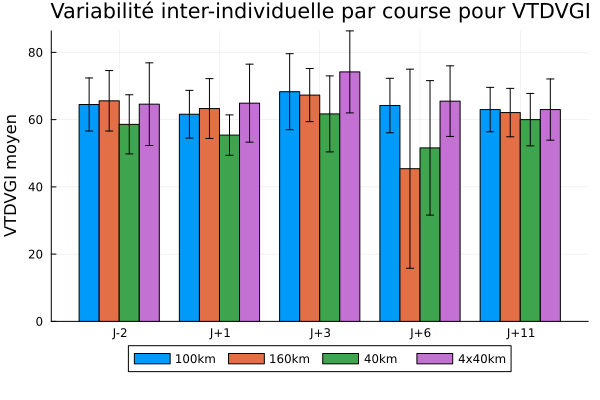

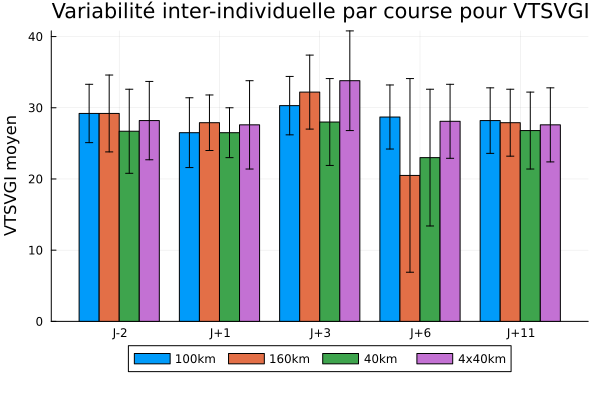

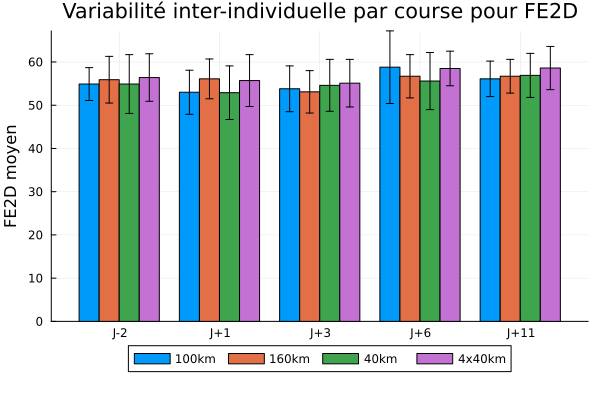

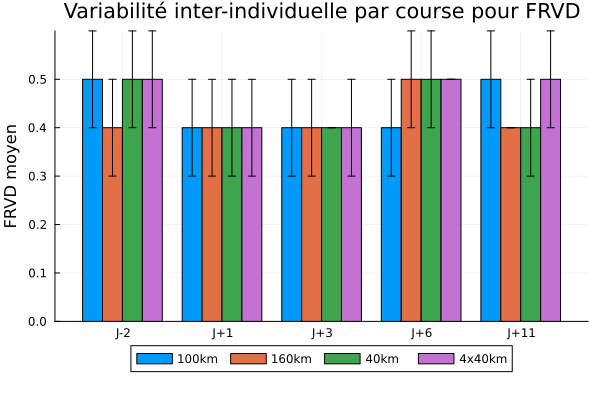

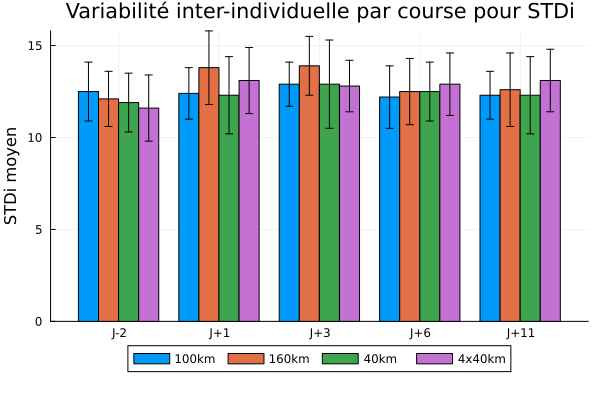

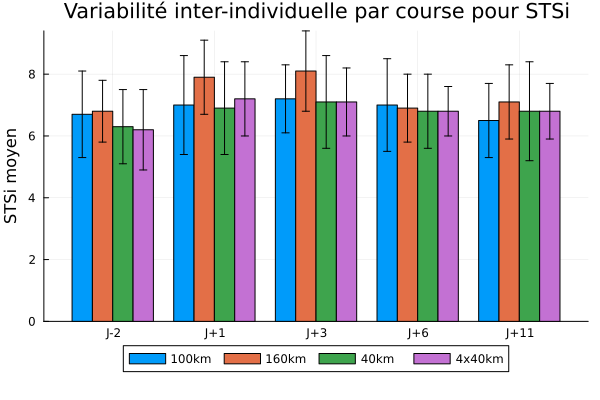

In [159]:
# Création d'une fonction pour afficher la variabilité intra-individuelle par course et par visite
function plotvariabilityinter(df, col)
    col2 = col*"_mean_std"
    df = hcat(df[:, 1:2], getindex.(df[:,Symbol(col2)], 1), getindex.(df[:,Symbol(col2)], 2), makeunique=true)
    df = filter(row -> !ismissing(row[:x1]) && !isnan(row[:x1]), df)
    df = filter(row -> !ismissing(row[:x1_1]) && !isnan(row[:x1_1]), df)

    # Replacement des valeurs de time 
    replacements = Dict(-2 => "1", 1 => "2", 3 => "3", 6 => "4", 11 => "5")
    df.TIME = map(x -> get(replacements, x, x), df.TIME)

    # Remplacement des valeurs de courses
    df.COURSE = string.(df.COURSE)
    replacements = Dict("100" => "100km", "4_40" => "4x40km", "160" => "160km", "40" => "40km")
    df.COURSE = map(x -> get(replacements, x, x), df.COURSE)
    return groupedbar(df[:,2], df[:,3], yerr = df[:,4], group = df[:,1], ylabel = col*" moyen", xticks=([0.5,1.5,2.5,3.5,4.5],["J-2","J+1","J+3","J+6","J+11"]),
        title = "Variabilité inter-individuelle par course pour "*col, legend= :outerbottom, legendcolumns=4)
end
for vi in liste_VI
    display(plotvariabilityinter(result, vi))
end

Une autre représentation possible : 

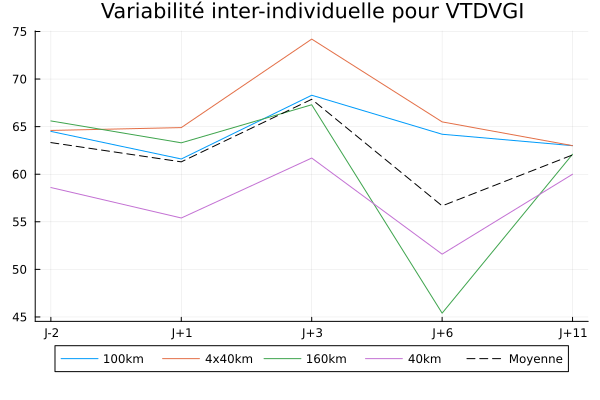

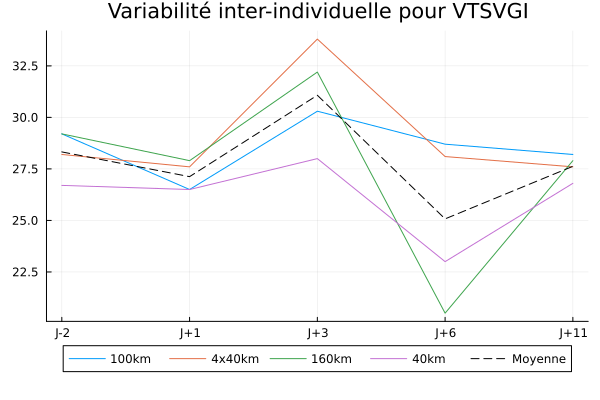

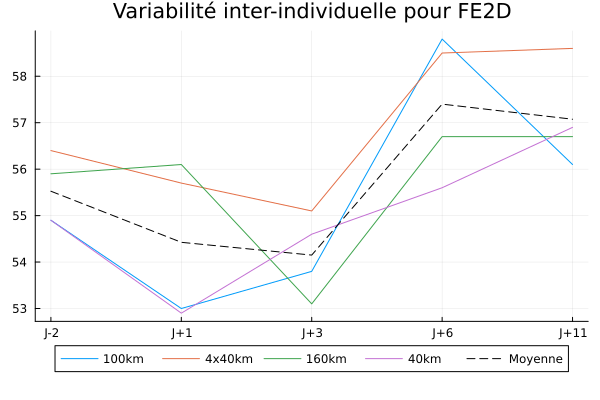

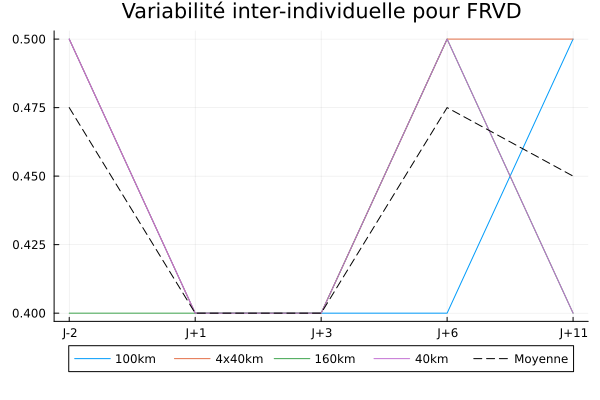

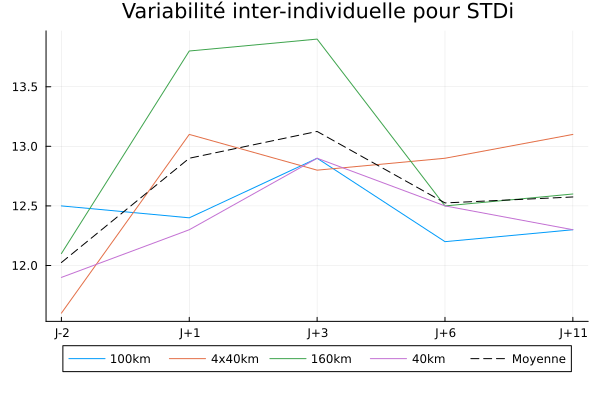

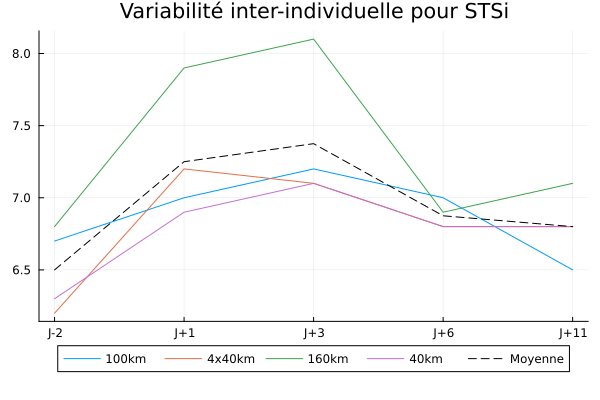

In [161]:
# Création d'une fonction pour afficher la variabilité intra-individuelle par course et par visite en courbe 
function plotlinevariabilityinter(df, col)
    col2 = col*"_mean_std"
    df = hcat(df[:, 1:2], getindex.(df[:,Symbol(col2)], 1), makeunique=true)
    grouped = groupby(df, :TIME)
    mean_values = combine(grouped, :x1 => (x -> mean(skipmissing(x))) => Symbol("mean_"*col))
    x = ["J-2","J+1","J+3","J+6","J+11"]
    C1 = first.(filter(row -> row.COURSE == 100, df)[:,"x1"])
    C2 = first.(filter(row -> row.COURSE == "4_40", df)[:,"x1"])
    C3 = first.(filter(row -> row.COURSE == 160, df)[:,"x1"])
    C4 = first.(filter(row -> row.COURSE == 40, df)[:,"x1"])
    Mean = mean_values[:,2]
    p = plot(x, [C1 C2 C3 C4], label=["100km" "4x40km" "160km" "40km"], title = "Variabilité inter-individuelle pour "*col)
    # Ajout de la cinquième courbe avec couleur spécifique et style en pointillé
    return plot!(p, x, Mean, label="Moyenne", linecolor=:black, linestyle=:dash, legend= :outerbottom, legendcolumns=5)
end
for vi in liste_VI
    display(plotlinevariabilityinter(result, vi))
end

## Tests d'hypothèses

Dans cette partie, nous allons faire des tests d'égalité des moyennes entre PRE et POST (J-2 et J+1) pour chaque course.

In [186]:
function mean_test(df::DataFrame,val_study::String)
    # Filtrer les lignes où la colonne TIME est égale à "-2" et "1"
    filtered_rows_PRE = filter(row -> row.TIME == -2, df)
    filtered_rows_POST = filter(row -> row.TIME == 1, df)

    # Sélectionner uniquement les colonnes TIME et val_study
    filtered_df_PRE = filtered_rows_PRE[:, [Symbol(val_study), :COURSE]]
    rename!(filtered_df_PRE, Symbol(val_study) => "PRE")

    filtered_df_POST = filtered_rows_POST[:, [Symbol(val_study)]]
    rename!(filtered_df_POST, Symbol(val_study) => "POST")
    

    # Combiner les DataFrames
    combined_df = hcat(filtered_df_PRE, filtered_df_POST)
    combined_df = dropmissing(combined_df)
    
    
    # Convertir les colonnes en Float64 et catégoriser COURSE
    
    combined_df[!, Symbol("PRE")] = convert.(Float64, combined_df[!, Symbol("PRE")])
    combined_df[!, Symbol("POST")] = convert.(Float64, combined_df[!, Symbol("POST")])
    combined_df.COURSE = string.(combined_df.COURSE)
    combined_df.COURSE = categorical(combined_df.COURSE)

    course_name = unique(filter(x -> x != "4_40", combined_df.COURSE))
    pvalues = []
    for course in course_name
        course_df = filter(row -> row.COURSE == course, combined_df)
        x = course_df[!,:PRE]
        y = course_df[!,:POST]
        push!(pvalues,pvalue(OneSampleTTest(x, y)))
    end
    return pvalues
    
end

mean_test (generic function with 1 method)

Les pvaleurs non corrigées associé à chaque tests : 

In [188]:
col_names = ["100", "40", "160"]
results = DataFrame(COURSE=String[], PValue=Float64[], Column=String[])

df_results = DataFrame(COURSE=liste_VI)
for (i, col_name) in enumerate(col_names)
    df_results[!, Symbol(col_name)] = [mean_test(res, var)[i] for var in liste_VI]
end

# Inverser les lignes et les colonnes
df_results_transposed = permutedims(df_results, :COURSE)
df_results_transposed

3×7 DataFrame
 Row │ COURSE  VTDVGI     VTSVGI     FE2D      FRVD       STDi         STSi    ⋯
     │ String  Float64    Float64    Float64   Float64    Float64      Float64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 100     0.203544   0.0743086  0.370328  0.393364   0.944651     0.52671 ⋯
   2 │ 40      0.0682626  0.850616   0.497404  0.0809479  0.406247     0.04248
   3 │ 160     0.612307   0.954117   0.71111   0.214854   0.000695863  8.1812e
                                                                1 column omitted

In [191]:
function create_corr_pval_dataframe(pvalues::Vector{Float64}, method)
    pval_adj = adjust(pvalues, method)
    matcorrected = fill(0.0, 3, 6)
    compteur = 1
    for i in 1:3
        for j in 1:6
            matcorrected[i,j] = pval_adj[compteur]
            compteur += 1
        end
    end
    matcorrected = hcat(["100", "40", "160"], matcorrected)
    col_name = ["COURSE", "VTDVGI", "VTSVGI", "FE2D", "FRVD", "STDi", "STSi"]
    df_final = DataFrame(matcorrected, Symbol.(col_name))
    return df_final
end

create_corr_pval_dataframe (generic function with 1 method)

Voici les résultats avec les corrections de Hochberg, Benjamini-Yakutelli et Benjamini-Hochberg : 

In [192]:
df_pval = df_results_transposed[!, Not(:COURSE)]
vector_pvalues = []
for i in 1:size(df_pval, 1)
    for j in 1:size(df_pval, 2)
        push!(vector_pvalues, df_pval[i, j])
    end
end
vector_pvalues = convert.(Float64,vector_pvalues)
display(create_corr_pval_dataframe(vector_pvalues, Hochberg()))
display(create_corr_pval_dataframe(vector_pvalues, BenjaminiYekutieli()))
display(create_corr_pval_dataframe(vector_pvalues, BenjaminiHochberg()))

3×7 DataFrame
 Row │ COURSE  VTDVGI    VTSVGI    FE2D      FRVD      STDi       STSi       
     │ Any     Any       Any       Any       Any       Any        Any        
─────┼───────────────────────────────────────────────────────────────────────
   1 │ 100     0.954117  0.954117  0.954117  0.954117  0.954117   0.954117
   2 │ 40      0.954117  0.954117  0.954117  0.954117  0.954117   0.67973
   3 │ 160     0.954117  0.954117  0.954117  0.954117  0.0118297  0.00147262

3×7 DataFrame
 Row │ COURSE  VTDVGI    VTSVGI    FE2D  FRVD      STDi      STSi       
     │ Any     Any       Any       Any   Any       Any       Any        
─────┼──────────────────────────────────────────────────────────────────
   1 │ 100     1.0       0.848765  1.0   1.0       1.0       1.0
   2 │ 40      0.848765  1.0       1.0   0.848765  1.0       0.848765
   3 │ 160     1.0       1.0       1.0   1.0       0.021889  0.00514695

3×7 DataFrame
 Row │ COURSE  VTDVGI    VTSVGI    FE2D      FRVD      STDi        STSi       
     │ Any     Any       Any       Any       Any       Any         Any        
─────┼────────────────────────────────────────────────────────────────────────
   1 │ 100     0.483422  0.242844  0.664768  0.664768  0.954117    0.729301
   2 │ 40      0.242844  0.954117  0.729301  0.242844  0.664768    0.242844
   3 │ 160     0.787252  0.954117  0.853332  0.483422  0.00626277  0.00147262